# Sentiment Analysis of News Outlets

- [Importing the Data](#Importing-the-Data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Preprocessing](#Data-Preprocessing)
- [Sentiment-Analysis](#Sentiment-Analysis)
    - [Calculation](#Calculation)
    - [Analysis](#Analysis)
- [Conclusion](#Conclusion)

<img src="./images/news_map.png">

The above image I found on [ad fontes media](https://www.adfontesmedia.com/the-chart-version-3-0-what-exactly-are-we-reading/#post/0). My goal for this project was to do sentiment analysis on different news media outlets. I set out to choose a liberal, neutral and conservative outlets. Based on the above chart, I settled on Palmer Report (liberal), Bloomberg (neutral) and Breitbart News (conservative). 

I used the twitter API to gather the tweets of my respective news outlets. The goal was to compare the subjectivity and the polarity scores. The python code where I gathered the data can be found in the file labeled scraping.py in the same directory. Below you can find the dictionary for the information that was gathered. For each news outlet 200 tweets were gathered.

|Feature|Type|Description|
|---|---|---|
|**id**|int|The integer representation of the unique identifier for this Tweet|
|**author**|str|Author of the tweet|
|**length**|int|Length of the full text of the tweet|
|**created_at**|str|UTC time when this Tweet was created (gathered as str)|
|**like_count**|int| Indicates approximately how many times this Tweet has been liked by Twitter users|
|**retweet_count**|int|Number of times this Tweet has been retweeted|
|**full_text**|str|The actual text of the status update|
|**source**|str|Utility used to post the Tweet, as an HTML-formatted string|

## Importing the Data

In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import re
import wordninja
from textblob import TextBlob

In [2]:
#The data is all saved in folder named 'data'
palmer_report = pd.read_csv('./data/palmer_report.csv')
bloomberg = pd.read_csv('./data/bloomberg.csv')
breitbart = pd.read_csv('./data/breitbart_news.csv')

In [3]:
palmer_report.head(2)

,id,author,length,created_at,like_count,retweet_count,full_text,source
0,1274834989121765378,PalmerReport,88,2020-06-21 22:42:01,36,9,Trump suffers humiliatingly senile moment duri...,Buffer
1,1274834203704807425,PalmerReport,174,2020-06-21 22:38:54,209,43,Ted Lieu has been hammering Donald Trump from ...,Twitter Web App


In [4]:
bloomberg.tail(2)

,id,author,length,created_at,like_count,retweet_count,full_text,source
198,1118867416719736834,Bloomberg,233,2019-04-18 13:22:34,35,14,The inclusion of yuan-denominated securities i...,Khoros Marketing
199,1118854216666292225,Bloomberg,75,2019-04-18 12:30:07,10,0,Get a glimpse into where we're taking @tictoc ...,Khoros Marketing


In [5]:
breitbart.head(2)

,id,author,length,created_at,like_count,retweet_count,full_text,source
0,1274835211134607368,BreitbartNews,53,2020-06-21 22:42:54,74,29,This is De Blasio's New York. https://t.co/eGF...,SocialFlow
1,1274829695830364164,BreitbartNews,124,2020-06-21 22:20:59,87,45,"Brett Favre believes Colin Kaepernick, like Ar...",SocialFlow


In [6]:
#checking to see if there is any NaN values
palmer_report.isnull().sum()

id               0
author           0
length           0
created_at       0
like_count       0
retweet_count    0
full_text        0
source           0
dtype: int64

In [7]:
bloomberg.isnull().sum()

id               0
author           0
length           0
created_at       0
like_count       0
retweet_count    0
full_text        0
source           0
dtype: int64

In [8]:
breitbart.isnull().sum()

id               0
author           0
length           0
created_at       0
like_count       0
retweet_count    0
full_text        0
source           0
dtype: int64

## Exploratory Data Analysis

From just a quick glance at random tweet I noticed that extensive data cleaning will be needed. The URLs that lead to full size articles will need to be stripped along with any mentioned that start with "@".

In [9]:
#visually taking a look at random samples of the text
print("Palmer Report:")
print(palmer_report['full_text'][np.random.choice(200)])
print()
print('Bloomberg:')
print(bloomberg['full_text'][np.random.choice(200)])
print()
print('Breitbart News:')
print(breitbart['full_text'][np.random.choice(200)])

Palmer Report:
RT @BetteWo67187229: Brad Parscale is in deep trouble tonight https://t.co/DCjfNKvVZa via @PalmerReport

Bloomberg:
RT @BloombergCareer: "We treat Diversity and Inclusion as we do every other business priority." Global Head of D&amp;I, Pamela Hutchinson share…

Breitbart News:
An illegal alien has been charged with raping an underage girl and providing her with alcohol in Gainseville, Georgia. https://t.co/fthZAvq4Fs


Next I was curious to take a look at the count of likes, retweets and length of the tweet over time for each outlet. When I looked at the description statistics of all three I noticed that while Bloomberg and Breitbart News followers tend to like a lot more than retweet, the Palmer Report followers are much more likely to retween when looking at the mean than like. Palmer Report, Bloomberg and Breitbart News had 331.7K, 579.3K and 1.3M followers respectively at the time of the scrape. The difference in the number of followers can also be evident by the number of likes and retweets when you compare all three. Breitbart News leads in the max count, Bloomberg takes second place and Palmer Report only goes up to max 10,000 likes. What is also interesting to see from the graphs below is that it seems that spikes in likes and retweets coincide with each other in most cases. While the length of the text doesn't seem to make a difference since it widely varies in all three outlets. 

In [10]:
palmer_report['like_count'].describe()

count      200.000000
mean       464.535000
std       1358.626593
min          0.000000
25%          0.000000
50%         77.000000
75%        278.500000
max      12483.000000
Name: like_count, dtype: float64

In [11]:
palmer_report['retweet_count'].describe()

count       200.000000
mean       1370.555000
std        8999.461006
min           3.000000
25%          31.000000
50%          48.500000
75%         104.250000
max      100599.000000
Name: retweet_count, dtype: float64

In [12]:
bloomberg['like_count'].describe()

count      200.000000
mean       568.055000
std       2368.050088
min          0.000000
25%          0.000000
50%          8.500000
75%         17.000000
max      16885.000000
Name: like_count, dtype: float64

In [13]:
bloomberg['retweet_count'].describe()

count     200.00000
mean       71.24500
std       226.50962
min         0.00000
25%         3.00000
50%         6.00000
75%        21.00000
max      1969.00000
Name: retweet_count, dtype: float64

In [14]:
breitbart['like_count'].describe()

count      200.000000
mean      1355.635000
std       3748.048943
min          0.000000
25%        187.500000
50%        510.500000
75%       1010.000000
max      32281.000000
Name: like_count, dtype: float64

In [15]:
breitbart['retweet_count'].describe()

count      200.000000
mean       710.850000
std       2294.625647
min         13.000000
25%        147.750000
50%        251.500000
75%        410.500000
max      21846.000000
Name: retweet_count, dtype: float64

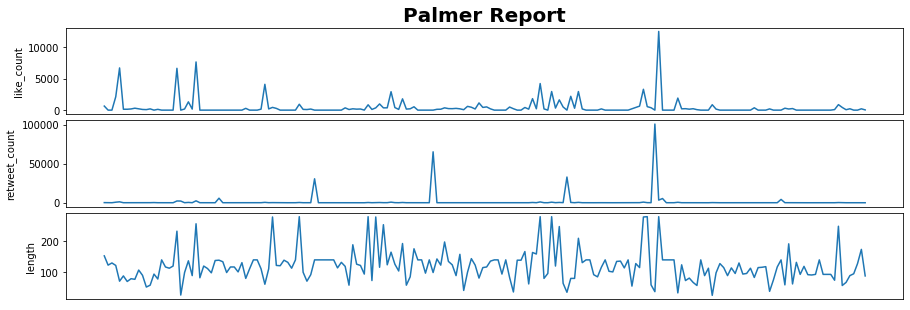

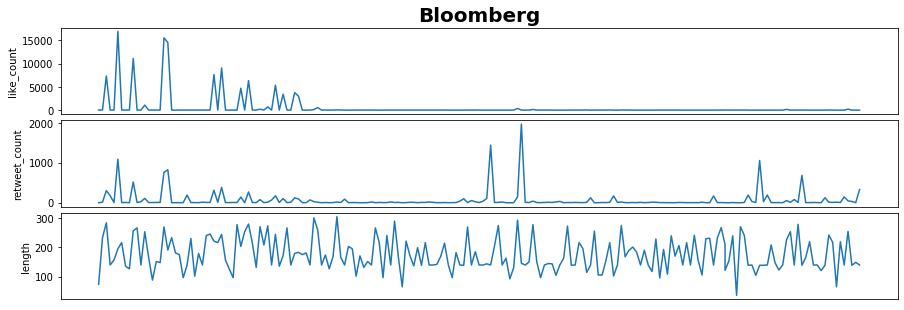

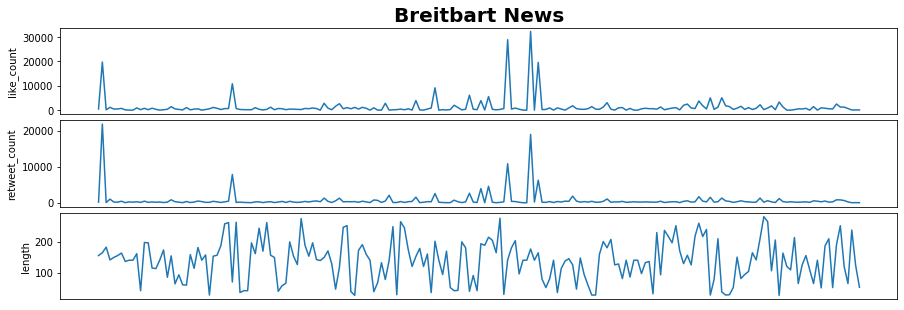

In [16]:
columns = ['like_count', 'retweet_count', 'length']
fig = plt.figure(figsize = [15,5])
fig.subplots_adjust(hspace=0.07, wspace = 0.04)
for count, column in enumerate(columns):
    ax = fig.add_subplot(len(columns), 1, count+1)
    ax.plot(palmer_report['created_at'][::-1], palmer_report[column][::-1]) 
    ax.set_ylabel(column)
    ax.get_xaxis().set_visible(False)
    if count == 0:
        ax.set_title('Palmer Report', weight = 'bold', fontsize = 20);
plt.show()        


columns = ['like_count', 'retweet_count', 'length']
fig = plt.figure(figsize = [15,5])
fig.subplots_adjust(hspace=0.07, wspace = 0.04)
for count, column in enumerate(columns):
    ax = fig.add_subplot(len(columns), 1, count+1)
    ax.plot(bloomberg['created_at'][::-1], bloomberg[column][::-1])
    ax.set_ylabel(column)
    ax.get_xaxis().set_visible(False)
    if count == 0:
        ax.set_title('Bloomberg', weight = 'bold', fontsize = 20);
plt.show()  

columns = ['like_count', 'retweet_count', 'length']
fig = plt.figure(figsize = [15,5])
fig.subplots_adjust(hspace=0.07, wspace = 0.04)
for count, column in enumerate(columns):
    ax = fig.add_subplot(len(columns), 1, count+1)
    ax.plot(breitbart['created_at'][::-1], breitbart[column][::-1])
    ax.set_ylabel(column)
    ax.get_xaxis().set_visible(False)
    if count == 0:
        ax.set_title('Breitbart News', weight = 'bold', fontsize = 20);
plt.show()  

I was curious to take a look at the tweets that ended up being the most liked and the most retweeted for each of the news media outlets. 

What is interesting to see from Palmer Report is that the most retweet tweet was actually a retweet to begin with of Tom Petty's tweet. For some reason though it had no likes? This could be explained by the fact that this was a recent tweet when scraped if not for the large amount of retweets. From Bloomberg we notice similar thing while the tweet is old from 2019. I made sure to look at the sentiment analysis of these tweets specifically below.

In [17]:
max_like_p = palmer_report.loc[palmer_report['like_count'].idxmax()]
max_retweet_p = palmer_report.loc[palmer_report['retweet_count'].idxmax()]
print('From Palmer Report:')
print()
print('Most Liked Tweet was:')
print(max_like_p['id'])
print(max_like_p['created_at'])
print(max_like_p['like_count'])
print(max_like_p['retweet_count'])
print(max_like_p['full_text'])

print()
print('Most Retweeted Tweet was:')
print(max_retweet_p['id'])
print(max_retweet_p['created_at'])
print(max_retweet_p['like_count'])
print(max_retweet_p['retweet_count'])
print(max_retweet_p['full_text'])

From Palmer Report:

Most Liked Tweet was:
1274590680581636097
2020-06-21 06:31:13
12483
3343
Don’t lose the plot. Fake ticket requests may have baited Parscale and Trump into overhyping things, but it didn’t keep any Trump fans from being able to attend or get in the door. There just weren’t many Trump fans interested in attending. His base is starting to give up on him.

Most Retweeted Tweet was:
1274588960581464070
2020-06-21 06:24:23
0
100599
RT @tompetty: https://t.co/mxToRoHWNn


In [18]:
max_like_bl = bloomberg.loc[bloomberg['like_count'].idxmax()]
max_retweet_bl = bloomberg.loc[bloomberg['retweet_count'].idxmax()]
print('From Bloomberg:')
print()
print('Most Liked Tweet was:')
print(max_like_bl['id'])
print(max_like_bl['created_at'])
print(max_like_bl['like_count'])
print(max_like_bl['retweet_count'])
print(max_like_bl['full_text'])

print()
print('Most Retweeted Tweet was:')
print(max_retweet_bl['id'])
print(max_retweet_bl['created_at'])
print(max_retweet_bl['like_count'])
print(max_retweet_bl['retweet_count'])
print(max_retweet_bl['full_text'])

From Bloomberg:

Most Liked Tweet was:
1121036099034451969
2019-04-24 13:00:08
16885
1090
Stock pickers in developing economies who base investment decisions on social parameters have generated substantial above-market returns in the past few years. #EarthMonth https://t.co/k6DjY3y8Cu

Most Retweeted Tweet was:
1187375409136066560
2019-10-24 14:28:52
0
1969
RT @TheTerminal: .@GlobalFishWatch data is now available at {MAP FISH &lt;GO&gt;} on the #BloombergTerminal, increasing transparency for business…


In [215]:
max_like_b = breitbart.loc[breitbart['like_count'].idxmax()]
max_retweet_b = breitbart.loc[breitbart['retweet_count'].idxmax()]
print('From Breitbart News:')
print()
print('Most Liked Tweet was:')
print(max_like_b['id'])
print(max_like_b['created_at'])
print(max_like_b['like_count'])
print(max_like_b['retweet_count'])
print(max_like_b['full_text'])

print()
print('Most Retweeted Tweet was:')
print(max_retweet_b['id'])
print(max_retweet_b['created_at'])
print(max_retweet_b['like_count'])
print(max_retweet_b['retweet_count'])
print(max_retweet_b['full_text'])

From Breitbart News:

Most Liked Tweet was:
1274363614078607361
2020-06-20 15:28:56
32281
18985
REVEALED: An anti-deportation group partnering with George Soros's Open Society Foundation is one of the groups behind the "defund the police" movement. https://t.co/rmSYGkC583

Most Retweeted Tweet was:
1273676937089749000
2020-06-18 18:00:20
19713
21846
HORROR: A report has uncovered a Berlin government-backed pedophile network that actively sought to place homeless children with pedophiles. https://t.co/EAhsImFopf


I also noticed that when gathering the data I gathered the source of the tweet. So I decided to quickly glanced at this too. I chose to graph a pie chart to compare all three. It appears that Palmer Report largely tweets from an iPhone.

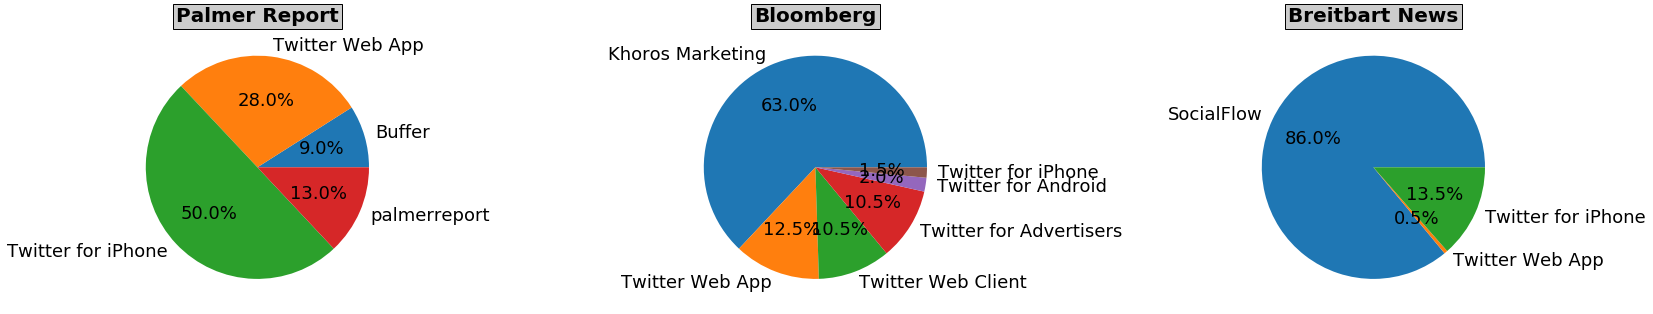

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (25,40)) # You'll want to specify your figsize
plt.subplots_adjust(hspace = 0.6, wspace = 1)

ax[0].pie(palmer_report.groupby('source').size(), 
        labels = palmer_report.groupby('source').size().index,
       autopct='%1.1f%%',
         textprops={'fontsize': 18})
ax[0].set_title('Palmer Report', weight = 'bold', fontsize = 20, bbox={'facecolor':'0.8', 'pad':3})

ax[1].pie(bloomberg.groupby('source').size(), 
        labels = bloomberg.groupby('source').size().index,
       autopct='%1.1f%%',
         textprops={'fontsize': 18})
ax[1].set_title('Bloomberg', weight = 'bold', fontsize = 20, bbox={'facecolor':'0.8', 'pad':3})

ax[2].pie(breitbart.groupby('source').size(), 
        labels = breitbart.groupby('source').size().index,
       autopct='%1.1f%%', textprops={'fontsize': 18});
ax[2].set_title('Breitbart News', weight = 'bold', fontsize = 20, bbox={'facecolor':'0.8', 'pad':3});

Before cleaning up the text data I wanted to quickly take a look at the most popular words of each outlet. Without diving in to the weeds of cleaning I used a CountVectorizer to remove stopwords, tokenize and separate the words. Then I graphed the top 10 words for each media outlet. It looks like Palmer Report (liberal) talks largely about Donald Trump. While Breitbart News (conservative), while also talks about Trump, also mentiones Joe Bidden a good number of times. Bloomberg tends to talk about business and global issues most often it seems. 

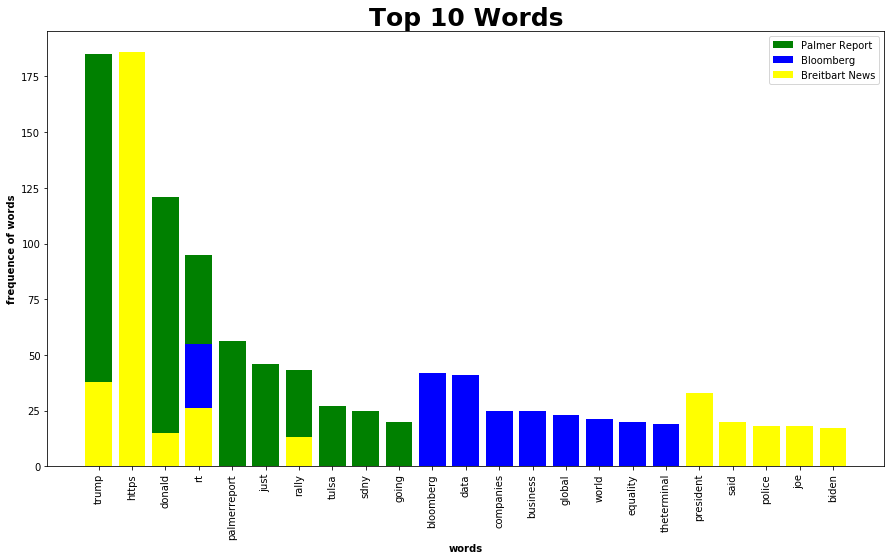

In [21]:
#DTM palmer report
cvec_pr = CountVectorizer(stop_words = 'english')
pr_cvec = cvec_pr.fit_transform(palmer_report['full_text'])
#transformaing CountVectorized text in to a data frame
pl_cv_df = pd.DataFrame(pr_cvec.todense(), columns = cvec_pr.get_feature_names())
pl_cv_df.index = palmer_report.index
#transposing the matrix and calculating the total amount of times the word was used
pl_cv_tran = pl_cv_df.transpose()
pl_cv_tran['total'] = pl_cv_tran.sum(axis = 1)


#DTM bloomberg
cvec_bl = CountVectorizer(stop_words = 'english')
bl_cvec = cvec_bl.fit_transform(bloomberg['full_text'])
#transformaing CountVectorized text in to a data frame
bl_cv_df = pd.DataFrame(bl_cvec.todense(), columns = cvec_bl.get_feature_names())
bl_cv_df.index = bloomberg.index
#transposing the matrix and calculating the total amount of times the word was used
bl_cv_tran = bl_cv_df.transpose()
bl_cv_tran['total'] = bl_cv_tran.sum(axis = 1)

#DTM breitbart
cvec_br = CountVectorizer(stop_words = 'english')
br_cvec = cvec_br.fit_transform(breitbart['full_text'])
#transformaing CountVectorized text in to a data frame
br_cv_df = pd.DataFrame(br_cvec.todense(), columns = cvec_br.get_feature_names())
br_cv_df.index = breitbart.index
#transposing the matrix and calculating the total amount of times the word was used
br_cv_tran = br_cv_df.transpose()
br_cv_tran['total'] = br_cv_tran.sum(axis = 1)



plt.figure(figsize=(15,8))
top_text_pl = pl_cv_tran.sort_values(by = ['total'], ascending = False)[:10]
top_text_bl = bl_cv_tran.sort_values(by = ['total'], ascending = False)[:10]
top_text_br = br_cv_tran.sort_values(by = ['total'], ascending = False)[:10]
plt.bar(top_text_pl.index, top_text_pl.total, color = 'green', label = 'Palmer Report')
plt.bar(top_text_bl.index, top_text_bl.total, color = 'blue', label = 'Bloomberg')
plt.bar(top_text_br.index, top_text_br.total, color = 'yellow', label = 'Breitbart News')
plt.xticks(rotation=90)
plt.legend()
plt.title('Top 10 Words', weight = 'bold', fontsize = 25)
plt.xlabel('words', weight = 'bold')
plt.ylabel('frequence of words', weight = 'bold');

## Data Preprocessing

Before doing the sentiment analysis with TextBlob I needed to clean up the text. Mainly remove hyperlinks, RT, @ mentions and #. Another thing I managed to do with the words that were hashtaged (#) is if the original format was "#EarthDay" the code changed it to "Earth Day". The last thing done was removing any emoji in the text. Below a few of the original tweet are printed out with then the cleaned up version of the text.

In [113]:
def preprocess(tweet):
    #removing RT and @ mention: for example --  "RT @lindaha96123336:"
    tweet = re.sub('RT @(.*?):', '', tweet)
    #removing the http://... hyperlink
    tweet = re.sub('https?:\/\/.*[\r\n]*', '', tweet)
    #removing # and if the word is concatenated (ex: EarthDay) split it in Earth Day
    #I split the words first before using ninja to preserve punctuation
    list_words = tweet.split(' ')
    for word in list_words:
        if '#' in word:
            new_word = word.replace('#', '')
            new_word = wordninja.split(new_word)
            new_word = ' '.join(new_word)
            tweet = tweet.replace(word, new_word)
    #if any "@" remains in the sentence
    tweet = tweet.replace('@', '')  
    #replace &amp; with and
    tweet.replace('&amp;', 'and')
    #stripping any emojis
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030""]+", re.UNICODE)                
    tweet = re.sub(emoj, '', tweet)
    #stripping any leading and ending spaces
    tweet = tweet.strip()
    return tweet

palmer_report['cleaned_text'] = palmer_report['full_text'].apply(preprocess)
bloomberg['cleaned_text'] = bloomberg['full_text'].apply(preprocess)
breitbart['cleaned_text'] = breitbart['full_text'].apply(preprocess)

In [122]:
#printing a few original tweets and cleaned up version for PalmerReport
for i in range(5):
    row = np.random.choice(200)
    print(palmer_report['full_text'][row])
    print()
    print(palmer_report['cleaned_text'][row])
    print()
    print()
   

Donald Trump just just got outdrawn by John Tesh of all people. No offense to John Tesh, but how does the sitting President of the United States lose out to John Tesh?

https://t.co/LIucNEksGo

Donald Trump just just got outdrawn by John Tesh of all people. No offense to John Tesh, but how does the sitting President of the United States lose out to John Tesh?


Donald Trump spent a shockingly large chunk of his speech making excuses for why he couldn't walk down a ramp. He blamed various problems on MS-13. He made lame excuses for why the arena was half empty. This was a complete disaster for him. #TrumpMeltdown

https://t.co/ivCaq2GAR8

Donald Trump spent a shockingly large chunk of his speech making excuses for why he couldn't walk down a ramp. He blamed various problems on MS-13. He made lame excuses for why the arena was half empty. This was a complete disaster for him. Trump Meltdown


You didn’t even fill the silent majority of those seats. https://t.co/POlyfahFTN

You didn’t eve

In [123]:
#printing a few original tweets and cleaned up version for Bloomberg
for i in range(5):
    row = np.random.choice(200)
    print(bloomberg['full_text'][row])
    print()
    print(bloomberg['cleaned_text'][row])
    print()
    print()

RT @neweconforum: Got a solution to a big problem? World leaders are listening. Submit your solution and it could end up in front of 500 of…

Got a solution to a big problem? World leaders are listening. Submit your solution and it could end up in front of 500 of…


RT @TheTerminal: We're expanding our range of regulatory reporting services with today's acquisition of https://t.co/YAEiT2YZvh, a leading…

We're expanding our range of regulatory reporting services with today's acquisition of


For #BloombergGEI member @Loreal, diversity is a priority. CEO Jean-Paul Agon and Head of Global Diversity &amp; Inclusion Margaret Johnston-Clarke talk why female representation matters. Learn more about the Bloomberg Gender-Equality Index: https://t.co/cL78V93pJb https://t.co/lwwLkI09QL

For Bloomberg GEI member Loreal, diversity is a priority. CEO Jean-Paul Agon and Head of Global Diversity &amp; Inclusion Margaret Johnston-Clarke talk why female representation matters. Learn more about the Bloo

In [124]:
#printing a few original tweets and cleaned up version for Breitbart News
for i in range(5):
    row = np.random.choice(200)
    print(breitbart['full_text'][row])
    print()
    print(breitbart['cleaned_text'][row])
    print()
    print()

WOW! https://t.co/IRLu6sz9tq

WOW!


HORROR: A report has uncovered a Berlin government-backed pedophile network that actively sought to place homeless children with pedophiles. https://t.co/EAhsImFopf

HORROR: A report has uncovered a Berlin government-backed pedophile network that actively sought to place homeless children with pedophiles.


The Establishment Media is twisting itself into a pretzel trying to somehow explain why tonight's Trump rally is dangerous but the WEEKS of massive protests are somehow different. https://t.co/9V5zSsySPO

The Establishment Media is twisting itself into a pretzel trying to somehow explain why tonight's Trump rally is dangerous but the WEEKS of massive protests are somehow different.


Left-wing documentary filmmaker Michael Moore is warning Democrats again. https://t.co/KEHuwyV8Dj

Left-wing documentary filmmaker Michael Moore is warning Democrats again.


No mask, no flight https://t.co/egpzlamwEd

No mask, no flight




## Sentiment Analysis

Now it was finally time for sentiment analysis. Calculating it was easy. Just a few lines. After calculating the polarity and subjectivity I analyzed the results. Keep in mind that polarity ranges between -1 and 1, where -1 is negative and 1 is positive sentiment. Subjectivity measures how subjective (i.e. opinion or fact) and ranges between 0 and 1 where 0 is mostly fact and 1 is mostly opinion. 

### Calculation

In [132]:
#calculating polarity and subjectivity of each tweet
polarity = lambda x: TextBlob(x).sentiment.polarity
subjectivity = lambda x: TextBlob(x).sentiment.subjectivity

palmer_report['polarity'] = palmer_report['cleaned_text'].apply(polarity)
palmer_report['subjectivity'] = palmer_report['cleaned_text'].apply(subjectivity)

bloomberg['polarity'] = bloomberg['cleaned_text'].apply(polarity)
bloomberg['subjectivity'] = bloomberg['cleaned_text'].apply(subjectivity)

breitbart['polarity'] = breitbart['cleaned_text'].apply(polarity)
breitbart['subjectivity'] = breitbart['cleaned_text'].apply(subjectivity)

In [204]:
#classifying each tweet as negative, positive or neutral
def classify(polarity):
    if polarity > 0:
        return 'positive'
    if polarity == 0: return 'neutral'
    else: return 'negative'
    
palmer_report['polarity_class'] = palmer_report['polarity'].apply(classify)
bloomberg['polarity_class'] = bloomberg['polarity'].apply(classify)
breitbart['polarity_class'] = breitbart['polarity'].apply(classify)

#is the tweet leaning towards fact or opinion
def subj(subjectivity):
    if subjectivity > 0.5: return 'opinion'
    else: return 'fact'
    
palmer_report['subj_class'] = palmer_report['subjectivity'].apply(subj)
bloomberg['subj_class'] = bloomberg['subjectivity'].apply(subj)
breitbart['subj_class'] = breitbart['subjectivity'].apply(subj)

In [205]:
palmer_report.head(2)

,id,author,length,created_at,like_count,retweet_count,full_text,source,cleaned_text,polarity,subjectivity,polarity_class,subj_class
0,1274834989121765378,PalmerReport,88,2020-06-21 22:42:01,36,9,Trump suffers humiliatingly senile moment duri...,Buffer,Trump suffers humiliatingly senile moment duri...,-0.6,0.70,negative,opinion
1,1274834203704807425,PalmerReport,174,2020-06-21 22:38:54,209,43,Ted Lieu has been hammering Donald Trump from ...,Twitter Web App,Ted Lieu has been hammering Donald Trump from ...,0.4,0.95,positive,opinion


In [206]:
bloomberg.head(2)

,id,author,length,created_at,like_count,retweet_count,full_text,source,cleaned_text,polarity,subjectivity,polarity_class,subj_class
0,1273970286312984576,Bloomberg,140,2020-06-19 13:26:00,0,329,RT @MikeBloomberg: We cannot wish equality int...,Twitter Web App,We cannot wish equality into existence.\n\nWe ...,0.1,0.200000,positive,fact
1,1273674457874300930,Bloomberg,149,2020-06-18 17:50:29,7,1,"This story, part of a monthly series appearing...",Twitter for Advertisers,"This story, part of a monthly series appearing...",0.0,0.166667,neutral,fact


In [207]:
breitbart.head(2)

,id,author,length,created_at,like_count,retweet_count,full_text,source,cleaned_text,polarity,subjectivity,polarity_class,subj_class
0,1274835211134607368,BreitbartNews,53,2020-06-21 22:42:54,74,29,This is De Blasio's New York. https://t.co/eGF...,SocialFlow,This is De Blasio's New York.,0.136364,0.454545,positive,fact
1,1274829695830364164,BreitbartNews,124,2020-06-21 22:20:59,87,45,"Brett Favre believes Colin Kaepernick, like Ar...",SocialFlow,"Brett Favre believes Colin Kaepernick, like Ar...",0.000000,0.000000,neutral,fact


### Analysis

Analyzing the data we can see that all three lean towards reporting mostly facts according to our model. The polarity though shows a different distribution. Bloomberg, which is our neutral news media outlet, seems to be mostly positive with 63% of the tweets. In fact only 12% of Bloomberg's tweet lean towards negative polarity. On the other hand our conservative (Breitbart News) and liberal (Palmer Report) tend to almost break up evenly between it's positive and negative polarity, while majority of the tweets are neutral. The percentage of neutral tweets for Palmer Report and Breitbart News is 43% and 42% respectively. 

In [193]:
#polarity percentage of tweets that are neutral, negative and positive
palmer_report['polarity_class'].value_counts(normalize = True)

neutral     0.43
negative    0.35
positive    0.22
Name: polarity_class, dtype: float64

In [194]:
bloomberg['polarity_class'].value_counts(normalize = True)

positive    0.625
neutral     0.260
negative    0.115
Name: polarity_class, dtype: float64

In [195]:
breitbart['polarity_class'].value_counts(normalize = True)

neutral     0.42
negative    0.30
positive    0.28
Name: polarity_class, dtype: float64

In [210]:
#is the tweet leaning towards fact or opinion
print(palmer_report['subj_class'].value_counts(normalize = True))
print()
print(bloomberg['subj_class'].value_counts(normalize = True))
print()
print(breitbart['subj_class'].value_counts(normalize = True))

fact       0.675
opinion    0.325
Name: subj_class, dtype: float64

fact       0.73
opinion    0.27
Name: subj_class, dtype: float64

fact       0.75
opinion    0.25
Name: subj_class, dtype: float64


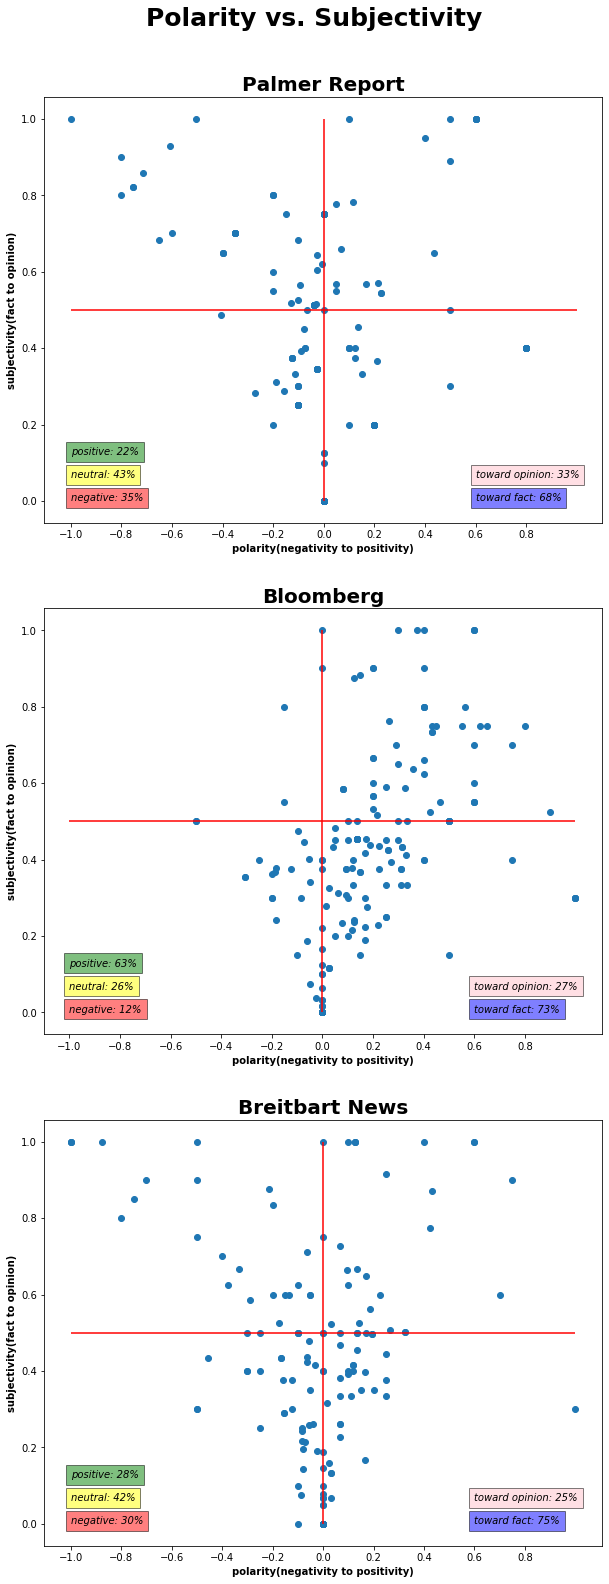

In [214]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize = (10,25)) # You'll want to specify your figsize
fig.suptitle('Polarity vs. Subjectivity', fontsize=25, fontweight='bold')
fig.subplots_adjust(top=0.93)

ax[0].scatter(palmer_report.polarity, palmer_report.subjectivity)
ax[0].set_title('Palmer Report', weight = 'bold', fontsize = 20)
ax[0].set_xticks(np.arange(-1, 1, step=0.2))
ax[0].set_xlabel('polarity(negativity to positivity)', weight = 'bold')
ax[0].set_ylabel('subjectivity(fact to opinion)', weight = 'bold')
ax[0].vlines(0, 0, 1, colors = 'r')
ax[0].hlines(0.5, -1, 1, colors = 'r')
ax[0].text(-1, 0, 'negative: 35%', style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 5})
ax[0].text(-1, 0.06, 'neutral: 43%', style='italic',
        bbox={'facecolor': 'yellow', 'alpha': 0.5, 'pad': 5})
ax[0].text(-1, 0.12, 'positive: 22%', style='italic',
        bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 5})
ax[0].text(0.6, 0, 'toward fact: 68%', style='italic',
        bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 5})
ax[0].text(0.6, 0.06, 'toward opinion: 33%', style='italic',
        bbox={'facecolor': 'pink', 'alpha': 0.5, 'pad': 5})


ax[1].scatter(bloomberg.polarity, bloomberg.subjectivity)
ax[1].set_title('Bloomberg', weight = 'bold', fontsize = 20)
ax[1].set_xticks(np.arange(-1, 1, step=0.2))
ax[1].set_xlabel('polarity(negativity to positivity)', weight = 'bold')
ax[1].set_ylabel('subjectivity(fact to opinion)', weight = 'bold')
ax[1].vlines(0, 0, 1, colors = 'r')
ax[1].hlines(0.5, -1, 1, colors = 'r')
ax[1].text(-1, 0, 'negative: 12%', style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 5})
ax[1].text(-1, 0.06, 'neutral: 26%', style='italic',
        bbox={'facecolor': 'yellow', 'alpha': 0.5, 'pad': 5})
ax[1].text(-1, 0.12, 'positive: 63%', style='italic',
        bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 5})
ax[1].text(0.6, 0, 'toward fact: 73%', style='italic',
        bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 5})
ax[1].text(0.6, 0.06, 'toward opinion: 27%', style='italic',
        bbox={'facecolor': 'pink', 'alpha': 0.5, 'pad': 5})

ax[2].scatter(breitbart.polarity, breitbart.subjectivity)
ax[2].set_title('Breitbart News', weight = 'bold', fontsize = 20)
ax[2].set_xticks(np.arange(-1, 1, step=0.2))
ax[2].set_xlabel('polarity(negativity to positivity)', weight = 'bold')
ax[2].set_ylabel('subjectivity(fact to opinion)', weight = 'bold')
ax[2].vlines(0, 0, 1, colors = 'r')
ax[2].hlines(0.5, -1, 1, colors = 'r')
ax[2].text(-1, 0, 'negative: 30%', style='italic',
        bbox={'facecolor': 'red', 'alpha': 0.5, 'pad': 5})
ax[2].text(-1, 0.06, 'neutral: 42%', style='italic',
        bbox={'facecolor': 'yellow', 'alpha': 0.5, 'pad': 5})
ax[2].text(-1, 0.12, 'positive: 28%', style='italic',
        bbox={'facecolor': 'green', 'alpha': 0.5, 'pad': 5})
ax[2].text(0.6, 0, 'toward fact: 75%', style='italic',
        bbox={'facecolor': 'blue', 'alpha': 0.5, 'pad': 5})
ax[2].text(0.6, 0.06, 'toward opinion: 25%', style='italic',
        bbox={'facecolor': 'pink', 'alpha': 0.5, 'pad': 5});


If you remember, above we took a look at the most popular tweets for each outlet. I mentioned above that I will take a look at it's polarity and subjectivity also. 

In [242]:
print('From Palmer Report:')
print()
print("Most Liked Tweet was:")
print(palmer_report[palmer_report['id'] == 1274590680581636097]['full_text'].values[0])
print()
print('polarity is: {}, that is {}'.format(palmer_report[palmer_report['id'] == 1274590680581636097]['polarity'].values[0],
                                          palmer_report[palmer_report['id'] == 1274590680581636097]['polarity_class'].values[0]))
print('subjectivity is: {}, that is {}'.format(palmer_report[palmer_report['id'] == 1274590680581636097]['subjectivity'].values[0],
                                              palmer_report[palmer_report['id'] == 1274590680581636097]['subj_class'].values[0]))
      
print()
print("Most Retweeted Tweet was:")
print(palmer_report[palmer_report['id'] == 1274588960581464070]['full_text'].values[0])
print()
print('polarity is: {}, that is {}'.format(palmer_report[palmer_report['id'] == 1274588960581464070]['polarity'].values[0],
                                          palmer_report[palmer_report['id'] == 1274588960581464070]['polarity_class'].values[0]))
print('subjectivity is: {}, that is {}'.format(palmer_report[palmer_report['id'] == 1274588960581464070]['subjectivity'].values[0],
                                              palmer_report[palmer_report['id'] == 1274588960581464070]['subj_class'].values[0]))

From Palmer Report:

Most Liked Tweet was:
Don’t lose the plot. Fake ticket requests may have baited Parscale and Trump into overhyping things, but it didn’t keep any Trump fans from being able to attend or get in the door. There just weren’t many Trump fans interested in attending. His base is starting to give up on him.

polarity is: -0.00833333333333334, that is negative
subjectivity is: 0.6208333333333333, that is opinion

Most Retweeted Tweet was:
RT @tompetty: https://t.co/mxToRoHWNn

polarity is: 0.0, that is neutral
subjectivity is: 0.0, that is fact


In [243]:
print('From Bloomberg:')
print()
print("Most Liked Tweet was:")
print(bloomberg[bloomberg['id'] == 1121036099034451969]['full_text'].values[0])
print()
print('polarity is: {}, that is {}'.format(bloomberg[bloomberg['id'] == 1121036099034451969]['polarity'].values[0],
                                           bloomberg[bloomberg['id'] == 1121036099034451969]['polarity_class'].values[0]))
print('subjectivity is: {}, that is {}'.format(bloomberg[bloomberg['id'] == 1121036099034451969]['subjectivity'].values[0],
                                              bloomberg[bloomberg['id'] == 1121036099034451969]['subj_class'].values[0]))
      
print()
print("Most Retweeted Tweet was:")
print(bloomberg[bloomberg['id'] == 1187375409136066560]['full_text'].values[0])
print()
print('polarity is: {}, that is {}'.format(bloomberg[bloomberg['id'] == 1187375409136066560]['polarity'].values[0],
                                          bloomberg[bloomberg['id'] == 1187375409136066560]['polarity_class'].values[0]))
print('subjectivity is: {}, that is {}'.format(bloomberg[bloomberg['id'] == 1187375409136066560]['subjectivity'].values[0],
                                              bloomberg[bloomberg['id'] == 1187375409136066560]['subj_class'].values[0]))

From Bloomberg:

Most Liked Tweet was:
Stock pickers in developing economies who base investment decisions on social parameters have generated substantial above-market returns in the past few years. #EarthMonth https://t.co/k6DjY3y8Cu

polarity is: -0.30416666666666664, that is negative
subjectivity is: 0.3541666666666667, that is fact

Most Retweeted Tweet was:
RT @TheTerminal: .@GlobalFishWatch data is now available at {MAP FISH &lt;GO&gt;} on the #BloombergTerminal, increasing transparency for business…

polarity is: 0.4, that is positive
subjectivity is: 0.4, that is fact


In [244]:
print('From Breitbart News:')
print()
print("Most Liked Tweet was:")
print(breitbart[breitbart['id'] == 1274363614078607361]['full_text'].values[0])
print()
print('polarity is: {}, that is {}'.format(breitbart[breitbart['id'] == 1274363614078607361]['polarity'].values[0],
                                          breitbart[breitbart['id'] == 1274363614078607361]['polarity_class'].values[0]))
print('subjectivity is: {}, that is {}'.format(breitbart[breitbart['id'] == 1274363614078607361]['subjectivity'].values[0],
                                              breitbart[breitbart['id'] == 1274363614078607361]['subj_class'].values[0]))
      
print()
print("Most Retweeted Tweet was:")
print(breitbart[breitbart['id'] == 1273676937089749000]['full_text'].values[0])
print()
print('polarity is: {}, that is {}'.format(breitbart[breitbart['id'] == 1273676937089749000]['polarity'].values[0],
                                          breitbart[breitbart['id'] == 1273676937089749000]['polarity_class'].values[0]))
print('subjectivity is: {}, that is {}'.format(breitbart[breitbart['id'] == 1273676937089749000]['subjectivity'].values[0],
                                              breitbart[breitbart['id'] == 1273676937089749000]['subj_class'].values[0]))

From Breitbart News:

Most Liked Tweet was:
REVEALED: An anti-deportation group partnering with George Soros's Open Society Foundation is one of the groups behind the "defund the police" movement. https://t.co/rmSYGkC583

polarity is: -0.2, that is negative
subjectivity is: 0.6, that is opinion

Most Retweeted Tweet was:
HORROR: A report has uncovered a Berlin government-backed pedophile network that actively sought to place homeless children with pedophiles. https://t.co/EAhsImFopf

polarity is: -0.13333333333333333, that is negative
subjectivity is: 0.6, that is opinion


# Conclusion

The goal of this project was to do a Sentiment Analysis on three different news media outlet Twitter accounts. I picked Palmer Report (liberal), Bloomberg (neutral), and Breitbart News (conservative) as my targets. Using the Twitter API and Tweepy I scraped the latest 200 posts from each. Before doing the Sentiment Analysis, I performed some Exploratory Data Analysis. First I took a look at the number of likes, retweets and length of the post. It appeared Bloomberg and Breitbart News readers tend to like posts more than retweet. It was the oposite for Palmer Report followers. Next came the tweets that were liked the most and retweeted the most. I found that the most liked tweets for Palmer Report and Breitbart News were of negative opinion nature. While for Bloomberg it appeared to be a negative fact according to the model. Taking a look at the most popular words in all of the tweets I found that Palmer Report tend to talk a lot about Donald Trump, while Breitbart News focuses on Joe Bidden. Finally getting to the Sentiment Analysis the model showed that Bloomberg appeared to be mostly factual and the most positive news media outlet. 